# Naive Gas Sensor Simulation
This note considers a simple approach at describing a gas sensor behavior during and after an analyte exposure. An effort is made to describe the transitioning and stabilization of sensor response using resistance time series and it's time derivatives.

In [1]:
# import pandas for data munching
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
# make plots pretty
import matplotlib.pyplot as plt
%matplotlib inline
# list all parameters by "print(plt.rcParams)" command
plt.rcParams['figure.figsize'] = (7.5, 7.5)
plt.rcParams['font.size'] = 15
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'w'

In [3]:
ri = 200 # initial baseline resistance of sensor channel prior to exposure
sampling_rate = 0.2 # seconds
df = pd.DataFrame(ri, index=pd.timedelta_range(start=0, end='5M', freq=f'{sampling_rate}S'), columns=['r'])

# add separate duration column with sampled time stream
df['t'] = df.index.total_seconds()

In [4]:
# simulate exposure and recovery of sensor channel for these times
te, tr = (60, 120) # exposure recovery in seconds
start = f'{te}S' # exposire/inflection time
stop = f'{tr}S' # end of exposure start of recovery

In [5]:
# simulate exponential response of sensor channel to exposure

Te = 250. # exposure stabilization period
rp = 100. # exposure plateu/staurated resistance

# now overwrite time series data for exposure interval
df.loc[start:stop,'r'] = (ri-rp)*np.exp(-(df.t[start:stop]-te)/Te) + rp

In [6]:
# now simulate recovery

Tr = 500 # recovery stabilization period
rp = ri # recovery plateu resistance

ri = df.r[stop] # beginning resistance at a start of recovery

# now overwrite time series data for recovery interval
df.loc[stop:,'r'] =  (ri-rp)*np.exp(-(df.t[stop:]-tr)/Tr)+rp

In [7]:
# add some noise to ground truth resistance

dr = 2.e-1 # noise amplitude in the units of kOhm
df['d'] = df.r + dr*np.random.randn(df.r.size)

In [8]:
# have a linear regression smoother over sliding window of nw samples
nw = 49

# setup x and y rolling windows
rrw = df.d.rolling(nw, center=True)
trw = df.t.rolling(nw, center=True)

# compute coefficients
k = rrw.cov(df.t)/trw.cov(df.t)
b = rrw.mean() - k*trw.mean()

# declare a smoothed column
df['s'] = k*df.t + b

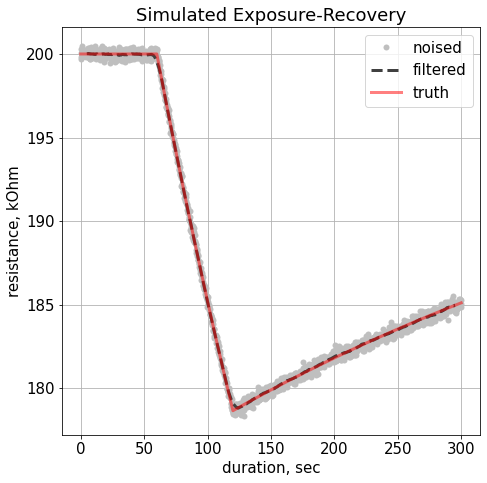

In [9]:
# examine your simulated data
plt.plot(df.t, df.d, c='0.75', ls='', marker='o',\
         markeredgecolor = 'none', label='noised')
plt.plot(df.t, df.s, c='0.25', lw=3, ls='--', label='filtered')
plt.plot(df.t, df.r, c='r', lw=3, alpha=0.5, label='truth')
plt.legend(loc='best')
plt.title("Simulated Exposure-Recovery")
plt.ylabel("resistance, kOhm")
plt.xlabel("duration, sec");

Compute first order derivative:
$$\frac{dr}{dt} = \dot{r} = \frac{r_p - r_i}{T}e^{-(t - t_i)/T} = \frac{r_p - r}{T}$$

Text(0.5, 0, 'duration, sec')

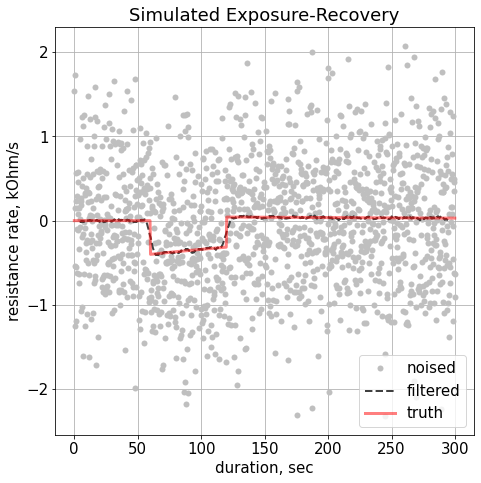

In [10]:
# compute first order derivatives
drdt = (df.r.shift(-1)-df.r.shift())/(df.t.shift(-1)-df.t.shift())
noise = (df.d.shift(-1)-df.d.shift())/(df.t.shift(-1)-df.t.shift())
# examine first derivatives
plt.plot(df.t, noise, c='0.75', ls='', marker='o',\
         markeredgecolor = 'none', label='noised')
plt.plot(df.t, k, c='0.25', lw=2, ls='--', label='filtered')
plt.plot(df.t, drdt, c='r', lw=3, alpha=0.5, label='truth')
plt.legend(loc=4)
plt.title("Simulated Exposure-Recovery")
plt.ylabel("resistance rate, kOhm/s")
plt.xlabel("duration, sec")

exposure halftime: 227.06 seconds
saturation resistance: 108.18 kOhm


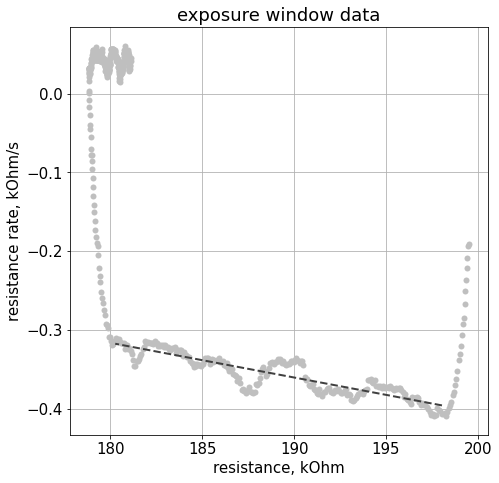

In [11]:
# now regress over exposure window
# end extract Te and rp of exposure

start, stop = f'{te }S', f'{tr}S'
r_exp = df.s[start:stop]
k_exp = k[start:stop]
plt.plot(r_exp, k_exp, c='0.75', ls='', marker='o',\
         markeredgecolor = 'none', label='noised')
plt.title('exposure window data')
plt.ylabel('resistance rate, kOhm/s')
plt.xlabel('resistance, kOhm')

# remove sidebands from selected exposure window
# to exclude the effect of inflection points
dt = nw*sampling_rate/2
start, stop = f'{te + dt}S', f'{tr - dt}S'
r_exp = df.s[start:stop]
k_exp = k[start:stop]

# do the fit
T_exp = -r_exp.var()/r_exp.cov(k_exp)
rp_exp = r_exp.mean() + T_exp*k_exp.mean()
plt.plot(r_exp,(rp_exp-r_exp)/T_exp, c='0.25', lw=2, ls='--')
print(f'exposure halftime: {T_exp:.2f} seconds\nsaturation resistance: {rp_exp:.2f} kOhm')

exposure halftime: 448.74 seconds
saturation resistance: 198.16 kOhm


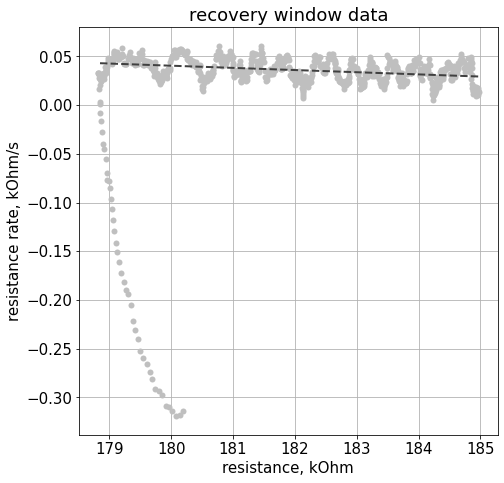

In [12]:
# now regress over recovery window
r_rec = df.s[stop:]
k_rec = k[stop:]
plt.plot(r_rec, k_rec, c='0.75', ls='', marker='o',\
         markeredgecolor = 'none', label='noised')
plt.title('recovery window data')
plt.ylabel('resistance rate, kOhm/s')
plt.xlabel('resistance, kOhm')

# remove sidebands from selected exposure window 
# to exclude the effect of inflection points
stop = f'{tr + dt}S'
r_rec = df.s[stop:]
k_rec = k[stop:]

# do the fit
T_rec = -r_rec.var()/r_rec.cov(k_rec)
rp_rec = r_rec.mean() + T_rec*k_rec.mean()
plt.plot(r_rec,(rp_rec-r_rec)/T_rec, c='0.25', lw=2, ls='--')
print(f'exposure halftime: {T_rec:.2f} seconds\nsaturation resistance: {rp_rec:.2f} kOhm')